# Milestone 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from dateutil.relativedelta import relativedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

##### Extracting quotes from politicians
In the following cell we load the provided metadata file, available [here](https://drive.google.com/drive/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0). This is used for obtaining a list of names of politicians, which we later use for filtering the QuoteBank dataset

In [2]:
df_meta = pd.read_parquet('speaker_attributes.parquet')
df_meta = df_meta[df_meta['occupation'].notna()]

# The identifier for the occupation politician in Wikidata is Q82955
politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]
politicians = politicians[politicians['aliases'].notna()]
politicians = politicians[politicians['label'].notna()]

# Make a combined list that contains both the aliases and the label names for the politicians
list_of_politicians = list(politicians.aliases.explode())
list_of_politicians += list(politicians.label)

We use the provided [Colab notebook](https://colab.research.google.com/drive/1NqLFrAWAzKxr2dAWHI7m6Ml3gWGF72cA?usp=sharing) for loading the QuoteBank dataset. This script creates a compressed file that is opened in the following cell

In [10]:
df_reader = pd.read_json('quotes-2020-domains.json.bz2', lines=True, compression='bz2', chunksize=10000)

df_politicians = pd.concat([
    chunk[chunk['speaker'].isin(list_of_politicians)]
    for chunk in df_reader])

KeyboardInterrupt: 

##### Save to disk
Since it takes quite some time to load and filter the data, let's save it to a compressed .csv file that we can se.

In [ ]:
compression_opts = dict(method='zip',archive_name='politicians.csv')  
df_politicians.to_csv('politicians.zip', index=False, compression=compression_opts)

##### Read from disk

In [3]:
df_politicians = pd.read_csv("politicians.csv")

# Quote time correlation
# TODO
##### Using quotes as signal
##### TODO  We retrieve all of Joe Biden's and Donald Trump's quotes for the year 2020 and the associated dates. We create a signal for each politician corresponding to the number of speeches recorded each week of the year. And finally we can visualise the correlation of the two signals but also the time lag between the two signals

In [4]:
signal_Joe_Biden = np.zeros([53,]) # 53 weeks in 2020 because of leap year
signal_Donald_Trump = np.zeros([53,]) # 53 weeks in 2020 because of leap year

biden_aliases = list(df_meta[df_meta['label'] == 'Joe Biden']['aliases'].values[0])

chunk_Joe_Biden = df_politicians[(df_politicians.speaker == "Joe Biden") | (df_politicians.speaker.isin(biden_aliases))]

chunk_Joe_Biden['date'] = chunk_Joe_Biden['date'].apply(pd.to_datetime)
weeks_Joe_Biden = chunk_Joe_Biden.date.apply(lambda x: x.week).values
signal_Joe_Biden, _ = np.histogram(weeks_Joe_Biden, range(1, signal_Joe_Biden.shape[0]+2))

trump_aliases = list(df_meta[df_meta['label'] == 'Donald Trump']['aliases'].values[0])
chunk_Donald_Trump = df_politicians[(df_politicians.speaker == "Donald Trump") | (df_politicians.speaker.isin(trump_aliases))] # Different ways to call him in the df

chunk_Donald_Trump['date'] = chunk_Donald_Trump['date'].apply(pd.to_datetime)
weeks_Donald_Trump = chunk_Donald_Trump.date.apply(lambda x: x.week).values
signal_Donald_Trump, _ = np.histogram(weeks_Donald_Trump, range(1, signal_Donald_Trump.shape[0]+2))

/var/folders/6y/wj5rbbbn4m3c5t1k5q50rrp40000gn/T/ipykernel_56799/2503504832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_Joe_Biden['date'] = chunk_Joe_Biden['date'].apply(pd.to_datetime)
/var/folders/6y/wj5rbbbn4m3c5t1k5q50rrp40000gn/T/ipykernel_56799/2503504832.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_Donald_Trump['date'] = chunk_Donald_Trump['date'].apply(pd.to_datetime)


##### Plot the results
Note that the reason for the signal becoming zero between week 10 and 20 is that the QuoteBank dataset was collected up until April 2020.

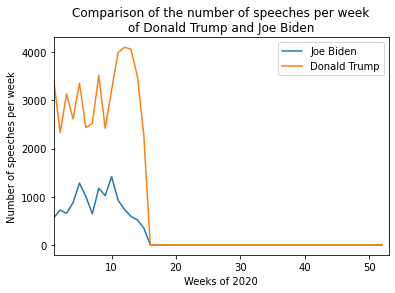

In [5]:
plt.plot(signal_Joe_Biden, label="Joe Biden")
plt.plot(signal_Donald_Trump, label="Donald Trump")
plt.xlim(1,signal_Donald_Trump.shape[0])
plt.xlabel("Weeks of 2020")
plt.ylabel("Number of speeches per week")
plt.title("Comparison of the number of speeches per week\nof Donald Trump and Joe Biden")
plt.legend();

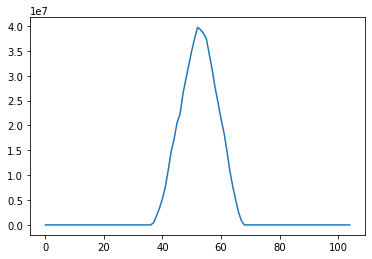

In [6]:
plt.plot(np.correlate(signal_Donald_Trump, signal_Joe_Biden, 'full')); # TODO get better interpetations

# Quote similarity
### In this section we will demonstrate how we can compute quote similarity using Tfidf. This will be demonstrated using quotes from Donald Trump and Joe Biden.

##### Extract and save Trump and Biden quote 

In [7]:
chunk_Donald_Trump.to_csv("Trump_2020_v2")
chunk_Joe_Biden.to_csv("Biden_2020_v2")

##### Read the csv saved of Trump and Biden

In [20]:
Trump = pd.read_csv("Trump_2020_v2")
Biden = pd.read_csv("Biden_2020_v2")

##### Learn the vocabulary from the quotes of all politcians in the data set 

In [9]:
corpus = df_politicians['quotation'].to_list()
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=['english'])
vectorizer = vectorizer.fit(corpus)

###### Pick a random quote from Donald Trump

In [21]:
random = 25
ref_Trump = Trump.loc[random]
trump_quote = [ref_Trump.quotation]

###### Extract quotes of Joe Biden within the following month after the quote by Donald Trump

In [22]:
ref_date = datetime.strptime(ref_Trump.date, '%Y-%m-%d %H:%M:%S')
end_date = ref_date + relativedelta(months=1)
Biden.date = Biden.date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
Biden_target = Biden[Biden.date>ref_date]
Biden_target = Biden_target[Biden_target.date<end_date]
Biden_target = Biden_target[["date", "quotation"]].sort_values(ascending=True, by="date")

##### Vectorize the quotes using Tfidf

In [23]:
biden_quotes = Biden_target.quotation.to_list()

trump_vec = vectorizer.transform(trump_quote)
biden_vec = vectorizer.transform(biden_quotes)

##### Rank the quotes of Joe Biden according to the cosine similarity to the quote by Donald Trump and select the most similar

In [27]:
similar_index = np.argmax(cosine_similarity(trump_vec, biden_vec))
print("Cosine similarity: %.3f" % cosine_similarity(trump_vec, biden_vec[similar_index])[0][0])
print("-------")
similar_quote = biden_quotes[similar_index]
print("Quote by Donald Trump: ",trump_quote[0])
print("-------")
print("Quote by Joe Biden: ",biden_quotes[similar_index])

Cosine similarity: 0.243
-------
Quote by Donald Trump:  He does good at rockets, too, by the way. I never saw where the engines come down with no wings, no anything, and they're landing.
-------
Quote by Joe Biden:  I was there a long time, Joe, and I never saw anything like that,
